In [1]:
from scipy.io import loadmat
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
data_dir = '/media/data_cifs_lrs/projects/prj_synchrony/data/BSR/BSDS500/data'
mat = np.squeeze(loadmat(os.path.join(data_dir, 'groundTruth/train/41004.mat'))['groundTruth'])
img = imread(os.path.join(data_dir, 'images/train/41004.jpg'))
segs = []
cts = []
for i in range(mat.shape[0]):
    segs.append(mat[i][0][0][0])
    cts.append(mat[i][0][0][1])

(320, 480)


(-0.5, 479.5, 319.5, -0.5)

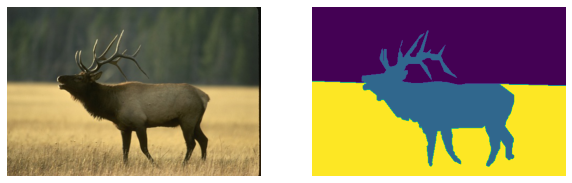

In [3]:
import cv2 as cv
h, w, _ = img.shape
# s = 1
# sm_img = cv.resize(img, (w//s, h//s))
# sm_seg = cv.resize(segs[2], (w//s, h//s))

sm_img = cv.resize(img, (480, 320))
sm_seg = cv.resize(segs[2], (480, 320))
print(sm_seg.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 30))
axes[0].imshow(sm_img)
axes[1].imshow(sm_seg)
axes[0].axis('off')
axes[1].axis('off')



In [7]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
#import ipdb
def circular_moments(phases, masks, split=False, burn_in_prop=.5):
    """
    phases: shape [steps, ...]
    masks(one hot indicator): shape [num_groups, ...]
    split: if return synch and desynch separately
    burn_in_prop: proportion of steps to be considered, steps before will not be added into loss
    """
    
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T) - 1
    masked_phases = phases.unsqueeze(1) * masks # [steps, num_groups, ...]
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_xx = xx.sum(-1) / group_size
    mean_yy = yy.sum(-1) / group_size
    mean_angles = torch.atan2(mean_yy, mean_xx)
    desynch = 0
    for m in np.arange(1, int(np.floor(num_groups/2.))+1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    
    loss = synch + desynch
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

In [9]:
#import ipdb
def cohn_loss(phases, masks, split=False, burn_in_prop=.5):
    """
    phases: shape [steps, ...]
    masks(one hot indicator): shape [num_groups, ...]
    split: if return synch and desynch separately
    burn_in_prop: proportion of steps to be considered, steps before will not be added into loss
    """
    
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T) - 1
    masked_phases = phases.unsqueeze(1) * masks # [steps, num_groups, ...]
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_xx = xx.sum(-1) / group_size
    mean_yy = yy.sum(-1) / group_size
    mean_angles = torch.atan2(mean_yy, mean_xx)
    phase_diffs = (mean_angles.unsqueeze(3) - mean_angles.unsqueeze(2))
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + 1e-5)) + np.log(2)).sum((1,2,3)) / (num_groups)**2
    
    loss = synch + desynch
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

In [30]:
class coupling_net_minju(torch.nn.Module):
    def __init__(self, feature_dim, num_hid_units=256):
        """
        Take in a set of embeddings of nodes and produce link weights. Weights will be produced separately, only the embeddings of two correponding nodes will be considered. Like relational networks.
        input: shape [batch_size, feature_dim]
        coupling(normalized unsymmetric): shape [batch_size, batch_size]
        """
        super(coupling_net_minju, self).__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2*feature_dim, num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_hid_units, num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_hid_units,1,bias=False)
        )
        
#         self.layers[-1].weight.data.zero_()
        
#         self.w=w#120
#         self.h=h#80
#         self.register_buffer('xx', torch.Tensor(np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[None,None,:,:] / w))
#         self.register_buffer('yy', torch.Tensor(np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[None,None,:,:] / h))
#         self.register_buffer('mask', torch.randperm(self.w * self.h))

    def forward(self, x, alpha=0.1, burnin_steps=150, num_steps=50, subset_size=128):
        b, c, o = x.size()
#         init_phase = (0.5 * torch.rand((o,)).float().unsqueeze(0).to(device) - 0.25) * np.pi + np.pi
        init_phase = torch.randn((o,)).float().unsqueeze(0).to(device) #* 2 * np.pi

        
#         Bx2 --> (bXb)x4 --> (bxb)x1 --> bxb
        
        with torch.no_grad():
            phase = init_phase
            for t in range(burnin_steps):
                mask = torch.randperm(o)[:subset_size].to(device).detach()

                _x = torch.index_select(x,2,mask)
                _x = _x.permute(0,2,1).view(-1, c)
                batch_size = _x.shape[0]
                _x = torch.cat([_x[:,None].repeat(1,batch_size,1), _x[None,:].repeat(batch_size,1,1)],dim=2)

                #Infer couplings 
                coupling = self.layers(_x.view(-1, _x.shape[-1])).squeeze().reshape(batch_size, batch_size)
                coupling = torch.nn.functional.normalize(coupling, p=2, dim=1)


                _phase = torch.index_select(phase,1,mask)[0]

    #             phase_diffs = torch.sin(_phase.unsqueeze(-1) - _phase.unsqueeze(-2))
                phase_diffs = torch.matmul(coupling, torch.sin(_phase).unsqueeze(1)).squeeze(1) * torch.cos(_phase)\
                        - torch.matmul(coupling, torch.cos(_phase).unsqueeze(1)).squeeze(1) * torch.sin(_phase)

                delta = alpha * phase_diffs
                phase.index_add_(1, mask, delta.unsqueeze(0))
            
            
        phase_flow = [phase]
        for t in range(num_steps):
            mask = torch.randperm(o)[:subset_size].to(device).detach()

            _x = torch.index_select(x,2,mask)
            _x = _x.permute(0,2,1).view(-1, c)
            batch_size = _x.shape[0]
            _x = torch.cat([_x[:,None].repeat(1,batch_size,1), _x[None,:].repeat(batch_size,1,1)],dim=2)

            #Infer couplings 
            coupling = self.layers(_x.view(-1, _x.shape[-1])).squeeze().reshape(batch_size, batch_size)
            coupling = torch.nn.functional.normalize(coupling, p=2, dim=1)

            phase = phase_flow[-1].clone()

            _phase = torch.index_select(phase,1,mask)[0]
            
#             phase_diffs = torch.sin(_phase.unsqueeze(-1) - _phase.unsqueeze(-2))
            phase_diffs = torch.matmul(coupling, torch.sin(_phase).unsqueeze(1)).squeeze(1) * torch.cos(_phase)\
                    - torch.matmul(coupling, torch.cos(_phase).unsqueeze(1)).squeeze(1) * torch.sin(_phase)
            
            delta = alpha * phase_diffs
            phase.index_add_(1, mask, delta.unsqueeze(0))
            phase_flow.append(phase)
            
        phase_flow = torch.stack(phase_flow[1:])
        _phase_flow = phase_flow.view(phase_flow.shape[0], 1, o)
        return _phase_flow
#         _phase_flow = torch.cat([torch.cos(_phase_flow), torch.sin(_phase_flow)],dim=1)
#         return self.decoder(_phase_flow), phase_flow

In [31]:
def phase_evol_ax(ax, phases, masks=None, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[0]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
        ax.set_ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            ax.set_plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')

In [32]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

# h, w, _ = sm_img.shape

# # binarize
# lb = LabelBinarizer()
# label = sm_seg.reshape(-1)
# label_bin = lb.fit_transform(label)

# label_bin[:,2]=0
# label_bin = np.concatenate([label_bin[:,:2], label_bin[:,3:]],axis=1)


# # concat coord
# xx = np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[None,:,:] / w
# yy = np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[None,:,:] / h 
# data = np.concatenate([np.transpose(sm_img, (2,0,1)), xx, yy], axis=0) / 255
# test_data = torch.Tensor(data).unsqueeze(0).to(device)        
# data = np.transpose(data, (1,2,0)).reshape(-1, 5)
        
# batches = 100
# skf = StratifiedKFold(batches, shuffle=True)

# train_prop = 0.2
# train_data = []
# train_label = []
# train_idx = []
# for i, (_, idx) in enumerate(skf.split(data, (label_bin * np.arange(label_bin.shape[1])).sum(1) )):
    
#     if i < batches*train_prop:
#         train_data.append(data[idx, :])
#         train_label.append(label_bin[idx])
#         train_idx.append(idx)
#     else:
#         break

# train_data = np.stack(train_data, axis=0)
# train_label = np.stack(train_label, axis=0)
# train_idx = np.stack(train_idx, axis=0)

# train_data = torch.from_numpy(train_data).to(device).float()
# train_label = torch.from_numpy(train_label).to(device)
# train_data = train_data.permute(0,2,1).unsqueeze(1)
# train_label = train_label.permute(0,2,1)

# test_label = torch.Tensor(label_bin).to(device)
# test_label = test_label.transpose(0,1)



h, w, _ = sm_img.shape

# binarize
lb = LabelBinarizer()
label = sm_seg.reshape(-1)
label_bin = lb.fit_transform(label)

label_bin[:,2]=0
label_bin = np.concatenate([label_bin[:,:2], label_bin[:,3:]],axis=1)


# concat coord
xx = np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[None,:,:] / w
yy = np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[None,:,:] / h 
data = np.concatenate([np.transpose(sm_img, (2,0,1)), xx, yy], axis=0) / 255

test_data = torch.Tensor(data).unsqueeze(0).to(device)        
test_label = torch.Tensor(label_bin).to(device)
test_label = test_label.transpose(0,1)


train_data = test_data.view(*test_data.shape[:2],-1).clone()

train_prop = 0.5
mask = torch.randperm(train_data.shape[-1])[:int(train_prop * train_data.shape[-1])].to(device).detach()
train_data = torch.index_select(train_data, 2, mask)
train_label = torch.index_select(test_label, 1, mask)    
    
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

torch.Size([1, 5, 76800])
torch.Size([3, 76800])
torch.Size([1, 5, 320, 480])
torch.Size([3, 153600])


0 5.163882732391357 0.7743215560913086 4.473164081573486 49.61323547363281


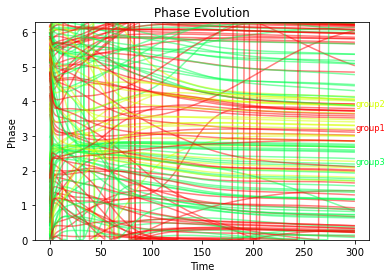

1 4.958286285400391 0.7069795727729797 4.252378940582275 17.381389617919922
2 4.831836223602295 0.6385839581489563 4.1919732093811035 8.060072898864746
3 4.772132873535156 0.5058038830757141 4.240976810455322 12.592642784118652
4 4.757414817810059 0.4438852071762085 4.268810749053955 24.318904876708984
5 4.700440883636475 0.46738672256469727 4.221628665924072 11.359609603881836
6 5.2679443359375 0.40402162075042725 4.9257378578186035 44.59679412841797
7 4.643006801605225 0.44728195667266846 4.19380521774292 10.386900901794434
8 4.488048553466797 0.2987898588180542 4.186957836151123 28.322444915771484
9 4.476880073547363 0.3006291389465332 4.1759033203125 7.7871222496032715
10 4.735931396484375 0.3931009769439697 4.362517356872559 59.23652267456055
11 4.547206878662109 0.31885457038879395 4.226011753082275 20.91098403930664
12 4.382078647613525 0.19973862171173096 4.182528495788574 10.67377758026123
13 4.422267436981201 0.15539836883544922 4.262796401977539 44.44546127319336
14 4.358335

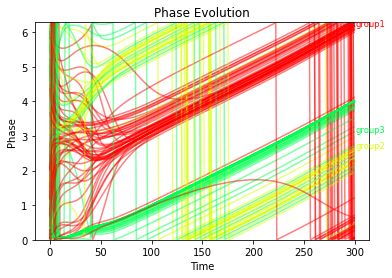

51 4.253379821777344 0.07563209533691406 4.177746295928955 1.6430586576461792
52 4.26786994934082 0.100028395652771 4.1678466796875 6.995112895965576
53 5.011056423187256 0.3501553535461426 4.43358850479126 25.293869018554688
54 4.3139753341674805 0.146803617477417 4.166574954986572 19.331806182861328
55 4.3594279289245605 0.19254451990127563 4.167365074157715 28.206693649291992
56 4.212007522583008 0.03836566209793091 4.173670291900635 2.6347250938415527
57 4.223455905914307 0.049512267112731934 4.173943519592285 1.5205134153366089
58 4.269195079803467 0.075553297996521 4.193641662597656 3.3106329441070557
59 4.2069993019104 0.03500610589981079 4.171992778778076 1.6887376308441162
60 4.229479789733887 0.05925548076629639 4.170224189758301 1.647213339805603
61 4.274343967437744 0.08528739213943481 4.18904972076416 4.983424186706543
62 4.235448837280273 0.057139039039611816 4.178309917449951 1.278681993484497
63 4.253586769104004 0.08277153968811035 4.170815467834473 2.3716893196105957


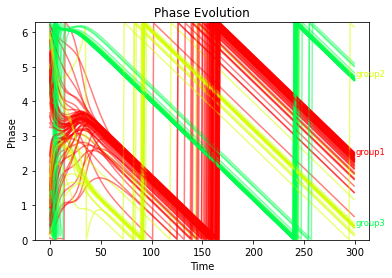

101 4.2646589279174805 0.09179401397705078 4.172852993011475 2.3888630867004395
102 4.2503838539123535 0.07891952991485596 4.1714630126953125 2.8371083736419678
103 4.229716777801514 0.0551447868347168 4.174571514129639 2.870760202407837
104 4.225754737854004 0.05631518363952637 4.169439792633057 6.7223992347717285
105 4.220441818237305 0.04837304353713989 4.172069072723389 3.258885145187378
106 4.223605632781982 0.04989290237426758 4.173712253570557 2.2183141708374023
107 4.232706069946289 0.05709421634674072 4.175612449645996 1.0984452962875366
108 4.221194744110107 0.03832721710205078 4.182867527008057 2.974001407623291
109 4.227803707122803 0.055134117603302 4.17266845703125 1.991416335105896
110 4.25086784362793 0.08572196960449219 4.1651458740234375 0.9007704854011536
111 4.219569683074951 0.048680126667022705 4.170892715454102 3.0491857528686523
112 4.260709285736084 0.0329509973526001 4.227802753448486 4.4511189460754395
113 4.281224727630615 0.11575686931610107 4.1654677391052

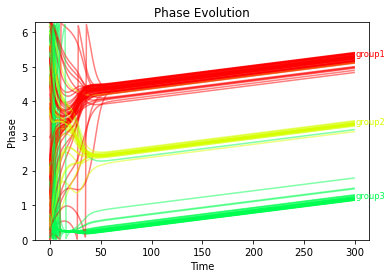

151 4.230433464050293 0.0652778148651123 4.165155410766602 0.664330005645752
152 4.20720100402832 0.0422244668006897 4.164976596832275 1.2698495388031006
153 4.210268020629883 0.0431099534034729 4.1671576499938965 1.601470708847046
154 4.224830150604248 0.05897188186645508 4.165858745574951 1.1195824146270752
155 4.272350788116455 0.1065375804901123 4.165801048278809 7.358559608459473
156 4.248057842254639 0.07926732301712036 4.168792724609375 1.170585036277771
157 4.200157642364502 0.02564030885696411 4.174520015716553 2.594550609588623
158 4.221412181854248 0.05636751651763916 4.165045261383057 2.0452253818511963
159 4.213161468505859 0.047507643699645996 4.165926456451416 2.9222288131713867
160 4.255126953125 0.08927083015441895 4.165757179260254 2.1725711822509766
161 4.195815086364746 0.027847588062286377 4.167967319488525 1.4512444734573364
162 4.198826789855957 0.03375697135925293 4.165070056915283 1.10593581199646
163 4.234930515289307 0.06883031129837036 4.166101932525635 1.90

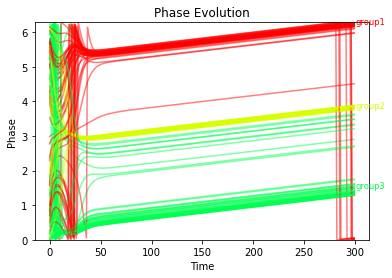

201 4.252964973449707 0.08600479364395142 4.166960716247559 2.9823904037475586
202 4.282835960388184 0.11405235528945923 4.168783664703369 2.063685655593872
203 4.223138809204102 0.0578080415725708 4.1653313636779785 1.864776849746704
204 4.225741386413574 0.0594172477722168 4.166324615478516 1.9509968757629395
205 4.214211463928223 0.040474534034729004 4.173737049102783 2.8025217056274414
206 4.257893085479736 0.06885910034179688 4.189035892486572 4.362060070037842
207 4.198019027709961 0.02571016550064087 4.172308921813965 2.167418956756592
208 4.226432800292969 0.057419419288635254 4.169013977050781 0.7577618360519409
209 4.199378490447998 0.024640798568725586 4.174727439880371 1.3731588125228882
210 4.229285717010498 0.06129801273345947 4.1679887771606445 1.3590432405471802
211 4.205141544342041 0.03946363925933838 4.165675640106201 1.2578134536743164
212 4.209634780883789 0.04295998811721802 4.166674613952637 1.1485236883163452
213 4.188934326171875 0.018576443195343018 4.17035722

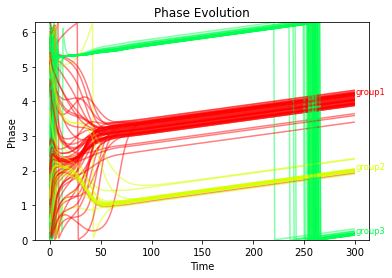

251 4.191885471343994 0.019599080085754395 4.172287940979004 1.4480904340744019
252 4.2381768226623535 0.07309401035308838 4.165083885192871 1.238017201423645
253 4.368160724639893 0.17333757877349854 4.194578647613525 3.7919085025787354
254 4.220837116241455 0.05586320161819458 4.164975643157959 0.7809189558029175
255 4.2368388175964355 0.06808501482009888 4.168215751647949 0.7675352096557617
256 4.2489848136901855 0.08438217639923096 4.164603233337402 2.8949592113494873
257 4.240039348602295 0.06978654861450195 4.170338153839111 1.5865594148635864
258 4.2231125831604 0.04371082782745361 4.179615020751953 3.197711229324341
259 4.203916549682617 0.036573708057403564 4.167342185974121 0.8722128868103027
260 4.232907772064209 0.055403053760528564 4.1775007247924805 2.746727705001831
261 4.197890758514404 0.030331730842590332 4.1675591468811035 0.5943183898925781
262 4.241755962371826 0.058780789375305176 4.1829705238342285 2.515413522720337
263 4.234957218170166 0.05913949012756348 4.174

In [33]:

alpha = 0.1#0.2
num_oscilators = 128#2400
subset_size=128
burnin_steps=100#100#200#150
num_steps=50
num_epochs = 300
lr = 2e-4#5e-4 #1e-4

net = coupling_net_minju(feature_dim=5, num_hid_units=256).to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)
for epoch in range(num_epochs):
    mask = torch.randperm(train_data.shape[-1])[:num_oscilators].to(device).detach()
    x = torch.index_select(train_data, 2, mask)
    y = torch.index_select(train_label, 1, mask)
#     x = train_data
#     y = train_label
    optim.zero_grad()
    
    phases = net(x, alpha=alpha, burnin_steps=burnin_steps, num_steps=num_steps, subset_size=subset_size)
    loss, synch, desynch = cohn_loss(phases, y, burn_in_prop=0, split=True)

#     loss = loss / num_steps

    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
    print(epoch, loss.item(), synch.item(), desynch.item(), norm.item())
    optim.step()
    if epoch % 50 == 0:
        with torch.no_grad():
            phases = net(x, alpha=alpha, burnin_steps=0, num_steps=300, subset_size=subset_size)
        fig, ax = plt.subplots()
        phase_evol_ax(ax, phases.cpu().data.numpy(), y.cpu().data.numpy())
        plt.show()
        plt.close()

#         with torch.no_grad():
#             phases = net(test_data.view(*test_data.shape[:2], -1), alpha=alpha, burnin_steps=0, num_steps=3000)
# #         fig, ax = plt.subplots()
# #         phase_evol_ax(ax, phases.cpu().data.numpy(), test_label.cpu().data.numpy())
# #         plt.show()
# #         plt.close()
#         plt.figure()
#         plt.imshow(phases[-1,0].view(test_data.shape[2], test_data.shape[3]).cpu().data.numpy() % (2*np.pi))
#         plt.savefig('%d.png' % epoch)
#         plt.show()
#         plt.close()

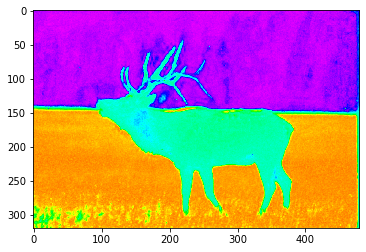

In [42]:
with torch.no_grad():
    phases = net(test_data.view(*test_data.shape[:2], -1), alpha=alpha, burnin_steps=int(1e5)-10, num_steps=10)

plt.figure()
plt.imshow((phases[-1,0].view(test_data.shape[2], test_data.shape[3]).cpu().data.numpy() + 1)  % (2*np.pi), cmap=plt.get_cmap('hsv'))
plt.savefig('%d.png' % epoch)
plt.show()
plt.close()